# Model and Training

## Load the model

In [1]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
ON_COLAB = False  # Set to True if running on Google Colab
if ON_COLAB:
    !pip install dotenv
    
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()


# Configuration
target_size_for_training = (128, 128)
data_root = f"./raw_data"  # root directory containing 'train' and 'test' subfolders
if ON_COLAB:
    from google.colab import drive

    drive.mount(os.getenv("GOOGLE_DRIVE_CONTENT_PATH", "/content/drive"))
    data_root = os.getenv("GOOGLE_DRIVE_PATH_RESIZED", data_root)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")
model_save_dir = os.getenv("MODEL_SAVE_DIR", "./checkpoints")
os.makedirs(model_save_dir, exist_ok=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
IMAGE_SIZE = target_size_for_training[0]

# 2. Define the UNet diffusion model
from model import get_unet_model

model = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
).to(DEVICE)

# Print model summary
def print_model_summary(model):
    print("Model Summary:")
    print(f"Model Type: {type(model).__name__}")
    print(f"Number of Parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Device: {next(model.parameters()).device}")

print_model_summary(model)


# 5. Load the model checkpoint if available
def load_checkpoint(ckpt_path, model, optimizer=None, device=torch.device("cpu")):
    loaded = False
    if not os.path.exists(ckpt_path):
        print(f"No checkpoint found at {ckpt_path}, starting fresh.")
        return loaded, model, optimizer, 0

    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Rimuovi il prefisso "_orig_mod." dalle chiavi se presente
    new_state_dict = {}
    for k, v in checkpoint["model"].items():
        if k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
            new_state_dict[new_k] = v
        else:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    model.to(device)
    loaded = True
    start_epoch = checkpoint.get("epoch", 0)
    
    if optimizer is not None and "optimizer" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer"])
        print(f"Loaded optimizer state from checkpoint '{ckpt_path}'")
    else:
        print("Optimizer state not found in checkpoint, starting with a new optimizer.")
    
    print(f"Loaded checkpoint '{ckpt_path}' (epoch {start_epoch})")
    return loaded, model, optimizer, start_epoch


WEIGHT_DECAY = 1e-5  # weight decay for regularization
optimizer = torch.optim.Adam(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

# Load the model checkpoint
ckpt = "checkpoints/ddim_unet_epoch20.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    ckpt, model, optimizer, device=DEVICE
)
model.eval()
if isModelLoadedFromCheckpoint:
    print(f"Model {ckpt.split('/')[-1]} loaded and moved to {DEVICE}, starting from epoch {start_epoch}.")
else:
    print(f"Model {ckpt.split('/')[-1]} not found. Starting from scratch, loaded on {DEVICE}, starting from epoch {start_epoch}.")

train_losses, val_losses = [], []

/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch20.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch20.pth' (epoch 20)
Model ddim_unet_epoch20.pth loaded and moved to cuda, starting from epoch 20.


## Training and validation

In [2]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import NUM_TRAIN_TIMESTEPS, sample_images, AugmentedDataset, save_checkpoint

# Config
BATCH_SIZE = 16
NUM_EPOCHS = 20
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_dataset = AugmentedDataset(root_dir=train_dir, image_size=IMAGE_SIZE)
test_dataset = AugmentedDataset(root_dir=test_dir, image_size=IMAGE_SIZE)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True
)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# Scheduler and Model Setup
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)
ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

        # if step % (len(train_loader) // 3) == 0:
        #     print(f"Reached step {step} of epoch {epoch}. Saving sample image and weights.")
        #     sample_images(
        #         output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}_step_{step}.png",
        #         num_steps=NUM_TRAIN_TIMESTEPS,
        #         DEVICE=DEVICE,
        #         IMAGE_SIZE=IMAGE_SIZE,
        #         model=model,
        #         ddim_scheduler=ddim_scheduler,
        #     )
        #     ckpt_path = os.path.join(
        #         model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}_step{step}.pth"
        #     )
        #     save_checkpoint(
        #         model=model,
        #         optimizer=optimizer,
        #         epoch=epoch + start_epoch,
        #         path=ckpt_path,
        #     )

    sample_images(
        output_path=f"{model_save_dir}/epoch_{epoch + start_epoch}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 13224
Validation samples: 1308
Training on cuda | Batch Size: 16 | Epochs: 20 | Starting at epoch 20
[Epoch 1/20 | Step 50/827] Train Loss: 0.003687
[Epoch 1/20 | Step 100/827] Train Loss: 0.006230
[Epoch 1/20 | Step 150/827] Train Loss: 0.006234
[Epoch 1/20 | Step 200/827] Train Loss: 0.003620
[Epoch 1/20 | Step 250/827] Train Loss: 0.004187
[Epoch 1/20 | Step 300/827] Train Loss: 0.005167
[Epoch 1/20 | Step 350/827] Train Loss: 0.009289
[Epoch 1/20 | Step 400/827] Train Loss: 0.009819
[Epoch 1/20 | Step 450/827] Train Loss: 0.009065
[Epoch 1/20 | Step 500/827] Train Loss: 0.011442
[Epoch 1/20 | Step 550/827] Train Loss: 0.004098
[Epoch 1/20 | Step 600/827] Train Loss: 0.003452
[Epoch 1/20 | Step 650/827] Train Loss: 0.009868
[Epoch 1/20 | Step 700/827] Train Loss: 0.009282
[Epoch 1/20 | Step 750/827] Train Loss: 0.008340
[Epoch 1/20 | Step 800/827] Train Loss: 0.006633
[Epoch 1/20 |

Sampling DDIM: 100%|██████████| 1000/1000 [00:25<00:00, 39.96it/s]

Sample saved to ./checkpoints/epoch_21.png
Epoch 1 complete. Avg Train Loss: 0.009194


Epoch 1 complete. Avg Validation Loss: 0.008917
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch21.pth
[Epoch 2/20 | Step 50/827] Train Loss: 0.012009
[Epoch 2/20 | Step 100/827] Train Loss: 0.007240
[Epoch 2/20 | Step 150/827] Train Loss: 0.005496
[Epoch 2/20 | Step 200/827] Train Loss: 0.024238
[Epoch 2/20 | Step 250/827] Train Loss: 0.002915
[Epoch 2/20 | Step 300/827] Train Loss: 0.013295
[Epoch 2/20 | Step 350/827] Train Loss: 0.006332
[Epoch 2/20 | Step 400/827] Train Loss: 0.012111
[Epoch 2/20 | Step 450/827] Train Loss: 0.009298
[Epoch 2/20 | Step 500/827] Train Loss: 0.003065
[Epoch 2/20 | Step 550/827] Train Loss: 0.006169
[Epoch 2/20 | Step 600/827] Train Loss: 0.008176
[Epoch 2/20 | Step 650/827] Train Loss: 0.033971
[Epoch 2/20 | Step 700/827] Train Loss: 0.003534
[Epoch 2/20 | Step 750/827] Train Loss: 0.003800
[Epoch 2/20 | Step 800/827] Train Loss: 0.013596
[Epoch 2/20 | Step 827/827] Train Loss: 0.002589


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.79it/s]

Sample saved to ./checkpoints/epoch_22.png
Epoch 2 complete. Avg Train Loss: 0.009984


Epoch 2 complete. Avg Validation Loss: 0.009683
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch22.pth
[Epoch 3/20 | Step 50/827] Train Loss: 0.007964
[Epoch 3/20 | Step 100/827] Train Loss: 0.006499
[Epoch 3/20 | Step 150/827] Train Loss: 0.007390
[Epoch 3/20 | Step 200/827] Train Loss: 0.003921
[Epoch 3/20 | Step 250/827] Train Loss: 0.004722
[Epoch 3/20 | Step 300/827] Train Loss: 0.019422
[Epoch 3/20 | Step 350/827] Train Loss: 0.009451
[Epoch 3/20 | Step 400/827] Train Loss: 0.003078
[Epoch 3/20 | Step 450/827] Train Loss: 0.006598
[Epoch 3/20 | Step 500/827] Train Loss: 0.003109
[Epoch 3/20 | Step 550/827] Train Loss: 0.006525
[Epoch 3/20 | Step 600/827] Train Loss: 0.005738
[Epoch 3/20 | Step 650/827] Train Loss: 0.005089
[Epoch 3/20 | Step 700/827] Train Loss: 0.006717
[Epoch 3/20 | Step 750/827] Train Loss: 0.024873
[Epoch 3/20 | Step 800/827] Train Loss: 0.001097
[Epoch 3/20 | Step 827/827] Train Loss: 0.015523


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.77it/s]


Sample saved to ./checkpoints/epoch_23.png
Epoch 3 complete. Avg Train Loss: 0.008652
Epoch 3 complete. Avg Validation Loss: 0.009023
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch23.pth
[Epoch 4/20 | Step 50/827] Train Loss: 0.003578
[Epoch 4/20 | Step 100/827] Train Loss: 0.020545
[Epoch 4/20 | Step 150/827] Train Loss: 0.016119
[Epoch 4/20 | Step 200/827] Train Loss: 0.010841
[Epoch 4/20 | Step 250/827] Train Loss: 0.011483
[Epoch 4/20 | Step 300/827] Train Loss: 0.020873
[Epoch 4/20 | Step 350/827] Train Loss: 0.004966
[Epoch 4/20 | Step 400/827] Train Loss: 0.004661
[Epoch 4/20 | Step 450/827] Train Loss: 0.004237
[Epoch 4/20 | Step 500/827] Train Loss: 0.002232
[Epoch 4/20 | Step 550/827] Train Loss: 0.008762
[Epoch 4/20 | Step 600/827] Train Loss: 0.003157
[Epoch 4/20 | Step 650/827] Train Loss: 0.016887
[Epoch 4/20 | Step 700/827] Train Loss: 0.007494
[Epoch 4/20 | Step 750/827] Train Loss: 0.003453
[Epoch 4/20 | Step 800/827] Train Loss: 0.007948
[Epoch 4/20 | Step 827/8

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.03it/s]

Sample saved to ./checkpoints/epoch_24.png
Epoch 4 complete. Avg Train Loss: 0.009097


Epoch 4 complete. Avg Validation Loss: 0.009517
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch24.pth
[Epoch 5/20 | Step 50/827] Train Loss: 0.015634
[Epoch 5/20 | Step 100/827] Train Loss: 0.006626
[Epoch 5/20 | Step 150/827] Train Loss: 0.007800
[Epoch 5/20 | Step 200/827] Train Loss: 0.003259
[Epoch 5/20 | Step 250/827] Train Loss: 0.002356
[Epoch 5/20 | Step 300/827] Train Loss: 0.011223
[Epoch 5/20 | Step 350/827] Train Loss: 0.003437
[Epoch 5/20 | Step 400/827] Train Loss: 0.005437
[Epoch 5/20 | Step 450/827] Train Loss: 0.006511
[Epoch 5/20 | Step 500/827] Train Loss: 0.006228
[Epoch 5/20 | Step 550/827] Train Loss: 0.029706
[Epoch 5/20 | Step 600/827] Train Loss: 0.005183
[Epoch 5/20 | Step 650/827] Train Loss: 0.005071
[Epoch 5/20 | Step 700/827] Train Loss: 0.009462
[Epoch 5/20 | Step 750/827] Train Loss: 0.014313
[Epoch 5/20 | Step 800/827] Train Loss: 0.006366
[Epoch 5/20 | Step 827/827] Train Loss: 0.005424


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.82it/s]

Sample saved to ./checkpoints/epoch_25.png
Epoch 5 complete. Avg Train Loss: 0.008766


Epoch 5 complete. Avg Validation Loss: 0.008398
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch25.pth
[Epoch 6/20 | Step 50/827] Train Loss: 0.040857
[Epoch 6/20 | Step 100/827] Train Loss: 0.006866
[Epoch 6/20 | Step 150/827] Train Loss: 0.004300
[Epoch 6/20 | Step 200/827] Train Loss: 0.003772
[Epoch 6/20 | Step 250/827] Train Loss: 0.030223
[Epoch 6/20 | Step 300/827] Train Loss: 0.002865
[Epoch 6/20 | Step 350/827] Train Loss: 0.002816
[Epoch 6/20 | Step 400/827] Train Loss: 0.006707
[Epoch 6/20 | Step 450/827] Train Loss: 0.013902
[Epoch 6/20 | Step 500/827] Train Loss: 0.012012
[Epoch 6/20 | Step 550/827] Train Loss: 0.004970
[Epoch 6/20 | Step 600/827] Train Loss: 0.006095
[Epoch 6/20 | Step 650/827] Train Loss: 0.010206
[Epoch 6/20 | Step 700/827] Train Loss: 0.004311
[Epoch 6/20 | Step 750/827] Train Loss: 0.006685
[Epoch 6/20 | Step 800/827] Train Loss: 0.007183
[Epoch 6/20 | Step 827/827] Train Loss: 0.016273


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.79it/s]

Sample saved to ./checkpoints/epoch_26.png
Epoch 6 complete. Avg Train Loss: 0.008836


Epoch 6 complete. Avg Validation Loss: 0.009472
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch26.pth
[Epoch 7/20 | Step 50/827] Train Loss: 0.007792
[Epoch 7/20 | Step 100/827] Train Loss: 0.020427
[Epoch 7/20 | Step 150/827] Train Loss: 0.003445
[Epoch 7/20 | Step 200/827] Train Loss: 0.009145
[Epoch 7/20 | Step 250/827] Train Loss: 0.004288
[Epoch 7/20 | Step 300/827] Train Loss: 0.003501
[Epoch 7/20 | Step 350/827] Train Loss: 0.003730
[Epoch 7/20 | Step 400/827] Train Loss: 0.005214
[Epoch 7/20 | Step 450/827] Train Loss: 0.003606
[Epoch 7/20 | Step 500/827] Train Loss: 0.014354
[Epoch 7/20 | Step 550/827] Train Loss: 0.014541
[Epoch 7/20 | Step 600/827] Train Loss: 0.028890
[Epoch 7/20 | Step 650/827] Train Loss: 0.005631
[Epoch 7/20 | Step 700/827] Train Loss: 0.006094
[Epoch 7/20 | Step 750/827] Train Loss: 0.012381
[Epoch 7/20 | Step 800/827] Train Loss: 0.004534
[Epoch 7/20 | Step 827/827] Train Loss: 0.016581


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.67it/s]

Sample saved to ./checkpoints/epoch_27.png
Epoch 7 complete. Avg Train Loss: 0.009033


Epoch 7 complete. Avg Validation Loss: 0.008695
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch27.pth
[Epoch 8/20 | Step 50/827] Train Loss: 0.012328
[Epoch 8/20 | Step 100/827] Train Loss: 0.005319
[Epoch 8/20 | Step 150/827] Train Loss: 0.004622
[Epoch 8/20 | Step 200/827] Train Loss: 0.006271
[Epoch 8/20 | Step 250/827] Train Loss: 0.014532
[Epoch 8/20 | Step 300/827] Train Loss: 0.004224
[Epoch 8/20 | Step 350/827] Train Loss: 0.010048
[Epoch 8/20 | Step 400/827] Train Loss: 0.008349
[Epoch 8/20 | Step 450/827] Train Loss: 0.003845
[Epoch 8/20 | Step 500/827] Train Loss: 0.006880
[Epoch 8/20 | Step 550/827] Train Loss: 0.004121
[Epoch 8/20 | Step 600/827] Train Loss: 0.010699
[Epoch 8/20 | Step 650/827] Train Loss: 0.016606
[Epoch 8/20 | Step 700/827] Train Loss: 0.005210
[Epoch 8/20 | Step 750/827] Train Loss: 0.008167
[Epoch 8/20 | Step 800/827] Train Loss: 0.007391
[Epoch 8/20 | Step 827/827] Train Loss: 0.006222


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.85it/s]


Sample saved to ./checkpoints/epoch_28.png
Epoch 8 complete. Avg Train Loss: 0.008897
Epoch 8 complete. Avg Validation Loss: 0.011043
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch28.pth
[Epoch 9/20 | Step 50/827] Train Loss: 0.004284
[Epoch 9/20 | Step 100/827] Train Loss: 0.005514
[Epoch 9/20 | Step 150/827] Train Loss: 0.024251
[Epoch 9/20 | Step 200/827] Train Loss: 0.011049
[Epoch 9/20 | Step 250/827] Train Loss: 0.005595
[Epoch 9/20 | Step 300/827] Train Loss: 0.006084
[Epoch 9/20 | Step 350/827] Train Loss: 0.007167
[Epoch 9/20 | Step 400/827] Train Loss: 0.003122
[Epoch 9/20 | Step 450/827] Train Loss: 0.009527
[Epoch 9/20 | Step 500/827] Train Loss: 0.007738
[Epoch 9/20 | Step 550/827] Train Loss: 0.020561
[Epoch 9/20 | Step 600/827] Train Loss: 0.010288
[Epoch 9/20 | Step 650/827] Train Loss: 0.009716
[Epoch 9/20 | Step 700/827] Train Loss: 0.006816
[Epoch 9/20 | Step 750/827] Train Loss: 0.011221
[Epoch 9/20 | Step 800/827] Train Loss: 0.004969
[Epoch 9/20 | Step 827/8

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]


Sample saved to ./checkpoints/epoch_29.png
Epoch 9 complete. Avg Train Loss: 0.008294
Epoch 9 complete. Avg Validation Loss: 0.010479
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch29.pth
[Epoch 10/20 | Step 50/827] Train Loss: 0.003162
[Epoch 10/20 | Step 100/827] Train Loss: 0.009142
[Epoch 10/20 | Step 150/827] Train Loss: 0.014416
[Epoch 10/20 | Step 200/827] Train Loss: 0.005681
[Epoch 10/20 | Step 250/827] Train Loss: 0.021462
[Epoch 10/20 | Step 300/827] Train Loss: 0.002501
[Epoch 10/20 | Step 350/827] Train Loss: 0.006007
[Epoch 10/20 | Step 400/827] Train Loss: 0.005487
[Epoch 10/20 | Step 450/827] Train Loss: 0.004347
[Epoch 10/20 | Step 500/827] Train Loss: 0.006266
[Epoch 10/20 | Step 550/827] Train Loss: 0.011630
[Epoch 10/20 | Step 600/827] Train Loss: 0.009397
[Epoch 10/20 | Step 650/827] Train Loss: 0.004012
[Epoch 10/20 | Step 700/827] Train Loss: 0.025543
[Epoch 10/20 | Step 750/827] Train Loss: 0.016406
[Epoch 10/20 | Step 800/827] Train Loss: 0.002833
[Epoch 1

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.81it/s]

Sample saved to ./checkpoints/epoch_30.png
Epoch 10 complete. Avg Train Loss: 0.008852


Epoch 10 complete. Avg Validation Loss: 0.009399
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch30.pth
[Epoch 11/20 | Step 50/827] Train Loss: 0.009306
[Epoch 11/20 | Step 100/827] Train Loss: 0.012564
[Epoch 11/20 | Step 150/827] Train Loss: 0.014124
[Epoch 11/20 | Step 200/827] Train Loss: 0.005787
[Epoch 11/20 | Step 250/827] Train Loss: 0.008607
[Epoch 11/20 | Step 300/827] Train Loss: 0.012765
[Epoch 11/20 | Step 350/827] Train Loss: 0.003011
[Epoch 11/20 | Step 400/827] Train Loss: 0.002475
[Epoch 11/20 | Step 450/827] Train Loss: 0.014518
[Epoch 11/20 | Step 500/827] Train Loss: 0.004390
[Epoch 11/20 | Step 550/827] Train Loss: 0.005318
[Epoch 11/20 | Step 600/827] Train Loss: 0.003789
[Epoch 11/20 | Step 650/827] Train Loss: 0.004689
[Epoch 11/20 | Step 700/827] Train Loss: 0.002296
[Epoch 11/20 | Step 750/827] Train Loss: 0.007385
[Epoch 11/20 | Step 800/827] Train Loss: 0.006321
[Epoch 11/20 | Step 827/827] Train Loss: 0.002975


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]

Sample saved to ./checkpoints/epoch_31.png
Epoch 11 complete. Avg Train Loss: 0.008844


Epoch 11 complete. Avg Validation Loss: 0.009542
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch31.pth
[Epoch 12/20 | Step 50/827] Train Loss: 0.004631
[Epoch 12/20 | Step 100/827] Train Loss: 0.009918
[Epoch 12/20 | Step 150/827] Train Loss: 0.009033
[Epoch 12/20 | Step 200/827] Train Loss: 0.005825
[Epoch 12/20 | Step 250/827] Train Loss: 0.035900
[Epoch 12/20 | Step 300/827] Train Loss: 0.005854
[Epoch 12/20 | Step 350/827] Train Loss: 0.009670
[Epoch 12/20 | Step 400/827] Train Loss: 0.017878
[Epoch 12/20 | Step 450/827] Train Loss: 0.003738
[Epoch 12/20 | Step 500/827] Train Loss: 0.002845
[Epoch 12/20 | Step 550/827] Train Loss: 0.010150
[Epoch 12/20 | Step 600/827] Train Loss: 0.006643
[Epoch 12/20 | Step 650/827] Train Loss: 0.003018
[Epoch 12/20 | Step 700/827] Train Loss: 0.004331
[Epoch 12/20 | Step 750/827] Train Loss: 0.015023
[Epoch 12/20 | Step 800/827] Train Loss: 0.009760
[Epoch 12/20 | Step 827/827] Train Loss: 0.004518


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]

Sample saved to ./checkpoints/epoch_32.png
Epoch 12 complete. Avg Train Loss: 0.008648


Epoch 12 complete. Avg Validation Loss: 0.009392
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch32.pth
[Epoch 13/20 | Step 50/827] Train Loss: 0.005590
[Epoch 13/20 | Step 100/827] Train Loss: 0.001232
[Epoch 13/20 | Step 150/827] Train Loss: 0.004243
[Epoch 13/20 | Step 200/827] Train Loss: 0.007421
[Epoch 13/20 | Step 250/827] Train Loss: 0.015763
[Epoch 13/20 | Step 300/827] Train Loss: 0.004805
[Epoch 13/20 | Step 350/827] Train Loss: 0.006592
[Epoch 13/20 | Step 400/827] Train Loss: 0.004285
[Epoch 13/20 | Step 450/827] Train Loss: 0.007003
[Epoch 13/20 | Step 500/827] Train Loss: 0.005890
[Epoch 13/20 | Step 550/827] Train Loss: 0.014571
[Epoch 13/20 | Step 600/827] Train Loss: 0.021375
[Epoch 13/20 | Step 650/827] Train Loss: 0.003644
[Epoch 13/20 | Step 700/827] Train Loss: 0.002127
[Epoch 13/20 | Step 750/827] Train Loss: 0.006399
[Epoch 13/20 | Step 800/827] Train Loss: 0.012524
[Epoch 13/20 | Step 827/827] Train Loss: 0.005000


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.83it/s]


Sample saved to ./checkpoints/epoch_33.png
Epoch 13 complete. Avg Train Loss: 0.008745
Epoch 13 complete. Avg Validation Loss: 0.011076
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch33.pth
[Epoch 14/20 | Step 50/827] Train Loss: 0.005961
[Epoch 14/20 | Step 100/827] Train Loss: 0.005171
[Epoch 14/20 | Step 150/827] Train Loss: 0.002934
[Epoch 14/20 | Step 200/827] Train Loss: 0.005164
[Epoch 14/20 | Step 250/827] Train Loss: 0.004509
[Epoch 14/20 | Step 300/827] Train Loss: 0.002889
[Epoch 14/20 | Step 350/827] Train Loss: 0.003282
[Epoch 14/20 | Step 400/827] Train Loss: 0.014006
[Epoch 14/20 | Step 450/827] Train Loss: 0.002553
[Epoch 14/20 | Step 500/827] Train Loss: 0.003869
[Epoch 14/20 | Step 550/827] Train Loss: 0.017718
[Epoch 14/20 | Step 600/827] Train Loss: 0.025147
[Epoch 14/20 | Step 650/827] Train Loss: 0.009571
[Epoch 14/20 | Step 700/827] Train Loss: 0.016310
[Epoch 14/20 | Step 750/827] Train Loss: 0.017932
[Epoch 14/20 | Step 800/827] Train Loss: 0.003545
[Epoch

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.71it/s]


Sample saved to ./checkpoints/epoch_34.png
Epoch 14 complete. Avg Train Loss: 0.009138
Epoch 14 complete. Avg Validation Loss: 0.009544
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch34.pth
[Epoch 15/20 | Step 50/827] Train Loss: 0.006387
[Epoch 15/20 | Step 100/827] Train Loss: 0.014474
[Epoch 15/20 | Step 150/827] Train Loss: 0.003616
[Epoch 15/20 | Step 200/827] Train Loss: 0.002859
[Epoch 15/20 | Step 250/827] Train Loss: 0.002658
[Epoch 15/20 | Step 300/827] Train Loss: 0.004124
[Epoch 15/20 | Step 350/827] Train Loss: 0.003209
[Epoch 15/20 | Step 400/827] Train Loss: 0.006569
[Epoch 15/20 | Step 450/827] Train Loss: 0.032421
[Epoch 15/20 | Step 500/827] Train Loss: 0.006824
[Epoch 15/20 | Step 550/827] Train Loss: 0.005741
[Epoch 15/20 | Step 600/827] Train Loss: 0.018373
[Epoch 15/20 | Step 650/827] Train Loss: 0.006751
[Epoch 15/20 | Step 700/827] Train Loss: 0.006156
[Epoch 15/20 | Step 750/827] Train Loss: 0.007373
[Epoch 15/20 | Step 800/827] Train Loss: 0.003249
[Epoch

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.80it/s]

Sample saved to ./checkpoints/epoch_35.png
Epoch 15 complete. Avg Train Loss: 0.008014


Epoch 15 complete. Avg Validation Loss: 0.009854
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch35.pth
[Epoch 16/20 | Step 50/827] Train Loss: 0.011060
[Epoch 16/20 | Step 100/827] Train Loss: 0.015321
[Epoch 16/20 | Step 150/827] Train Loss: 0.011455
[Epoch 16/20 | Step 200/827] Train Loss: 0.014498
[Epoch 16/20 | Step 250/827] Train Loss: 0.014998
[Epoch 16/20 | Step 300/827] Train Loss: 0.007102
[Epoch 16/20 | Step 350/827] Train Loss: 0.003588
[Epoch 16/20 | Step 400/827] Train Loss: 0.004838
[Epoch 16/20 | Step 450/827] Train Loss: 0.004842
[Epoch 16/20 | Step 500/827] Train Loss: 0.011940
[Epoch 16/20 | Step 550/827] Train Loss: 0.009891
[Epoch 16/20 | Step 600/827] Train Loss: 0.009558
[Epoch 16/20 | Step 650/827] Train Loss: 0.008321
[Epoch 16/20 | Step 700/827] Train Loss: 0.002924
[Epoch 16/20 | Step 750/827] Train Loss: 0.004224
[Epoch 16/20 | Step 800/827] Train Loss: 0.018485
[Epoch 16/20 | Step 827/827] Train Loss: 0.003314


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.86it/s]

Sample saved to ./checkpoints/epoch_36.png
Epoch 16 complete. Avg Train Loss: 0.008402


Epoch 16 complete. Avg Validation Loss: 0.010802
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch36.pth
[Epoch 17/20 | Step 50/827] Train Loss: 0.003164
[Epoch 17/20 | Step 100/827] Train Loss: 0.003275
[Epoch 17/20 | Step 150/827] Train Loss: 0.004333
[Epoch 17/20 | Step 200/827] Train Loss: 0.008495
[Epoch 17/20 | Step 250/827] Train Loss: 0.006917
[Epoch 17/20 | Step 300/827] Train Loss: 0.005214
[Epoch 17/20 | Step 350/827] Train Loss: 0.008247
[Epoch 17/20 | Step 400/827] Train Loss: 0.004814
[Epoch 17/20 | Step 450/827] Train Loss: 0.013148
[Epoch 17/20 | Step 500/827] Train Loss: 0.012594
[Epoch 17/20 | Step 550/827] Train Loss: 0.008232
[Epoch 17/20 | Step 600/827] Train Loss: 0.001243
[Epoch 17/20 | Step 650/827] Train Loss: 0.003271
[Epoch 17/20 | Step 700/827] Train Loss: 0.006328
[Epoch 17/20 | Step 750/827] Train Loss: 0.015729
[Epoch 17/20 | Step 800/827] Train Loss: 0.009582
[Epoch 17/20 | Step 827/827] Train Loss: 0.002091


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 43.85it/s]

Sample saved to ./checkpoints/epoch_37.png
Epoch 17 complete. Avg Train Loss: 0.008693


Epoch 17 complete. Avg Validation Loss: 0.010597
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch37.pth
[Epoch 18/20 | Step 50/827] Train Loss: 0.010829
[Epoch 18/20 | Step 100/827] Train Loss: 0.008971
[Epoch 18/20 | Step 150/827] Train Loss: 0.013428
[Epoch 18/20 | Step 200/827] Train Loss: 0.012429
[Epoch 18/20 | Step 250/827] Train Loss: 0.006317
[Epoch 18/20 | Step 300/827] Train Loss: 0.007482
[Epoch 18/20 | Step 350/827] Train Loss: 0.005682
[Epoch 18/20 | Step 400/827] Train Loss: 0.006270
[Epoch 18/20 | Step 450/827] Train Loss: 0.006200
[Epoch 18/20 | Step 500/827] Train Loss: 0.005763
[Epoch 18/20 | Step 550/827] Train Loss: 0.003276
[Epoch 18/20 | Step 600/827] Train Loss: 0.004138
[Epoch 18/20 | Step 650/827] Train Loss: 0.013189
[Epoch 18/20 | Step 700/827] Train Loss: 0.002411
[Epoch 18/20 | Step 750/827] Train Loss: 0.010691
[Epoch 18/20 | Step 800/827] Train Loss: 0.004148
[Epoch 18/20 | Step 827/827] Train Loss: 0.002233


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.82it/s]


Sample saved to ./checkpoints/epoch_38.png
Epoch 18 complete. Avg Train Loss: 0.008626
Epoch 18 complete. Avg Validation Loss: 0.010111
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch38.pth
[Epoch 19/20 | Step 50/827] Train Loss: 0.018043
[Epoch 19/20 | Step 100/827] Train Loss: 0.010842
[Epoch 19/20 | Step 150/827] Train Loss: 0.003204
[Epoch 19/20 | Step 200/827] Train Loss: 0.028318
[Epoch 19/20 | Step 250/827] Train Loss: 0.006175
[Epoch 19/20 | Step 300/827] Train Loss: 0.005072
[Epoch 19/20 | Step 350/827] Train Loss: 0.004148
[Epoch 19/20 | Step 400/827] Train Loss: 0.017064
[Epoch 19/20 | Step 450/827] Train Loss: 0.002978
[Epoch 19/20 | Step 500/827] Train Loss: 0.015681
[Epoch 19/20 | Step 550/827] Train Loss: 0.004097
[Epoch 19/20 | Step 600/827] Train Loss: 0.004927
[Epoch 19/20 | Step 650/827] Train Loss: 0.007425
[Epoch 19/20 | Step 700/827] Train Loss: 0.033238
[Epoch 19/20 | Step 750/827] Train Loss: 0.011830
[Epoch 19/20 | Step 800/827] Train Loss: 0.005692
[Epoch

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 44.94it/s]

Sample saved to ./checkpoints/epoch_39.png
Epoch 19 complete. Avg Train Loss: 0.008568


Epoch 19 complete. Avg Validation Loss: 0.008104
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch39.pth
[Epoch 20/20 | Step 50/827] Train Loss: 0.002443
[Epoch 20/20 | Step 100/827] Train Loss: 0.004955
[Epoch 20/20 | Step 150/827] Train Loss: 0.018973
[Epoch 20/20 | Step 200/827] Train Loss: 0.001872
[Epoch 20/20 | Step 250/827] Train Loss: 0.010384
[Epoch 20/20 | Step 300/827] Train Loss: 0.006005
[Epoch 20/20 | Step 350/827] Train Loss: 0.004264
[Epoch 20/20 | Step 400/827] Train Loss: 0.010633
[Epoch 20/20 | Step 450/827] Train Loss: 0.003837
[Epoch 20/20 | Step 500/827] Train Loss: 0.006814
[Epoch 20/20 | Step 550/827] Train Loss: 0.014814
[Epoch 20/20 | Step 600/827] Train Loss: 0.001609
[Epoch 20/20 | Step 650/827] Train Loss: 0.005802
[Epoch 20/20 | Step 700/827] Train Loss: 0.003556
[Epoch 20/20 | Step 750/827] Train Loss: 0.015540
[Epoch 20/20 | Step 800/827] Train Loss: 0.005531
[Epoch 20/20 | Step 827/827] Train Loss: 0.005017


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.14it/s]

Sample saved to ./checkpoints/epoch_40.png
Epoch 20 complete. Avg Train Loss: 0.008056


Epoch 20 complete. Avg Validation Loss: 0.009016
Checkpoint salvato in: ./checkpoints/ddim_unet_epoch40.pth


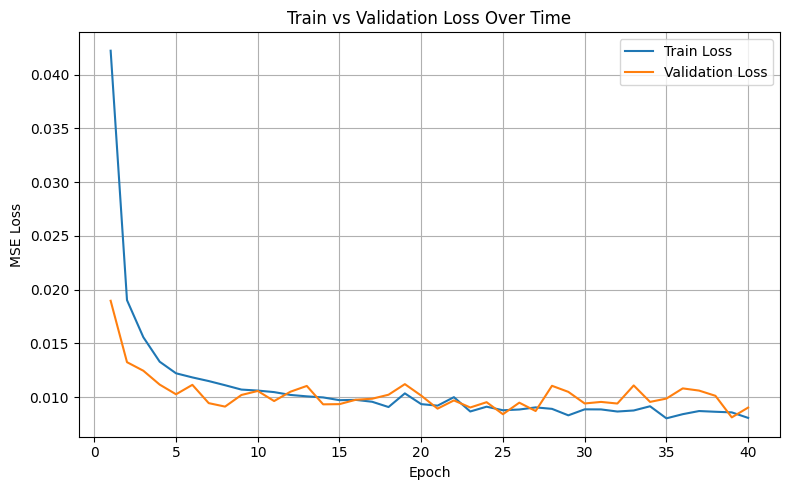

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Load existing history if it exists
all_train_losses = []
all_val_losses = []

if os.path.exists(history_file):
    with open(history_file, "r") as f:
        lines = f.readlines()[1:]  # Skip header
        for line in lines:
            _, train_loss, val_loss = line.strip().split("\t")
            all_train_losses.append(float(train_loss))
            all_val_losses.append(float(val_loss))

# Append current session's losses
all_train_losses.extend(train_losses)
all_val_losses.extend(val_losses)

# Save updated history
with open(history_file, "w") as f:
    f.write("Epoch\tTrain Loss\tValidation Loss\n")
    for i, (tr, vl) in enumerate(zip(all_train_losses, all_val_losses), 1):
        f.write(f"{i}\t{tr:.6f}\t{vl:.6f}\n")

# Plot full loss history
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(all_train_losses) + 1), all_train_losses, label="Train Loss")
plt.plot(range(1, len(all_val_losses) + 1), all_val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
from diffusers import DDPMScheduler, DDIMScheduler
from tqdm import tqdm
from utils import sample_images

# Imposta il numero di step di inferenza per DDIM (uguale a NUM_TRAIN_TIMESTEPS di default)
# 6. Sampling example with DDIM
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)

ddim_scheduler = DDIMScheduler(
    beta_start=noise_scheduler.config.beta_start,
    beta_end=noise_scheduler.config.beta_end,
    beta_schedule=noise_scheduler.config.beta_schedule,
    clip_sample=True,
)

ddim_scheduler.set_timesteps(NUM_TRAIN_TIMESTEPS)


# Sample images
for i in range(10):
    sample_images(
        output_path=f"result/ddim_sample_epoch{epoch + start_epoch}_{i}.png",
        num_steps=NUM_TRAIN_TIMESTEPS,
        DEVICE=DEVICE,
        IMAGE_SIZE=IMAGE_SIZE,
        model=model,
        ddim_scheduler=ddim_scheduler,
    )

Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.03it/s]


Sample saved to result/ddim_sample_epoch40_0.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.16it/s]


Sample saved to result/ddim_sample_epoch40_1.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.10it/s]


Sample saved to result/ddim_sample_epoch40_2.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.20it/s]


Sample saved to result/ddim_sample_epoch40_3.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.17it/s]


Sample saved to result/ddim_sample_epoch40_4.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.09it/s]


Sample saved to result/ddim_sample_epoch40_5.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.11it/s]


Sample saved to result/ddim_sample_epoch40_6.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.10it/s]


Sample saved to result/ddim_sample_epoch40_7.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.13it/s]


Sample saved to result/ddim_sample_epoch40_8.png


Sampling DDIM: 100%|██████████| 1000/1000 [00:22<00:00, 45.04it/s]

Sample saved to result/ddim_sample_epoch40_9.png
